# RSL-RL Policy Performance Comparison

Comprehensive performance analysis focusing on **locomotion tasks**:
- Flat vs Rough terrain
- Different robot platforms (Anymal-C, Anymal-D, Unitree Go2)
- Direct locomotion vs Manager-based control

All comparisons focus on the latest checkpoints from training.

In [15]:
# Import libraries and utilities
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

# Project root
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Add analysis scripts directory to sys.path
ANALYSIS_DIR = PROJECT_ROOT / "scripts" / "analysis"
sys.path.insert(0, str(ANALYSIS_DIR))

# Import (and optionally reload) analysis utilities
import rsl_rl_analysis_utils as _rsl_utils_mod
importlib.reload(_rsl_utils_mod)

from rsl_rl_analysis_utils import (
    COMPARISONS, METRIC_PATTERNS, refresh_comparisons_with_latest,
    load_all_metrics, extract_key_metrics,
    plot_comparison_bar, plot_training_curves, plot_multi_metric_bars,
    TENSORBOARD_AVAILABLE,
)

# Define directories
LOGS_DIR = PROJECT_ROOT / "logs" / "rsl_rl"
refresh_comparisons_with_latest(LOGS_DIR)
print("Using latest runs for each experiment in COMPARISONS")

print(f"Project root: {PROJECT_ROOT}")
print(f"Logs directory: {LOGS_DIR}")
print(f"TensorBoard available: {TENSORBOARD_AVAILABLE}")

Using latest runs for each experiment in COMPARISONS
Project root: /home/mahs/Development/project0/quadrrl
Logs directory: /home/mahs/Development/project0/quadrrl/logs/rsl_rl
TensorBoard available: True


## 1. Load All Metrics

Load training metrics from all TensorBoard log files for the runs defined in the comparison groups.


In [16]:
# Load all metrics
print("Loading metrics from TensorBoard logs...")
all_metrics = load_all_metrics(LOGS_DIR)

print(f"\nTotal runs loaded: {len(all_metrics)}")
print("\nLoaded runs:")
for run_key, run_data in all_metrics.items():
    num_metrics = len(run_data['metrics'])
    print(f"  - {run_data['display_name']}: {num_metrics} metrics")


Loading metrics from TensorBoard logs...

Total runs loaded: 6

Loaded runs:
  - Anymal-C Flat: 28 metrics
  - Anymal-C Rough: 29 metrics
  - Unitree Go2 Flat: 27 metrics
  - Unitree Go2 Rough: 27 metrics
  - Anymal-D Flat: 28 metrics
  - Anymal-D Rough: 29 metrics


In [17]:
# Extract key metrics into DataFrame
metrics_df = extract_key_metrics(all_metrics)

print(f"Metrics DataFrame shape: {metrics_df.shape}")
print(f"\nAvailable metric columns:")
metric_cols = [col for col in metrics_df.columns if col not in ['run_key', 'display_name', 'experiment', 'category']]
print(metric_cols)

# Show which metrics have data
print("\nMetrics with available data:")
for col in metric_cols:
    non_null = metrics_df[col].notna().sum()
    if non_null > 0:
        print(f"  {col}: {non_null}/{len(metrics_df)} runs have data")

# Display summary
display(metrics_df[['display_name', 'experiment', 'category'] + metric_cols[:5]].head())

# Save to CSV
    # metrics_csv = OUTPUT_DIR / "metrics_summary.csv"
    # metrics_df.to_csv(metrics_csv, index=False)
# print(f"\nMetrics summary saved to: {metrics_csv}")
  # Commented out


Metrics DataFrame shape: (6, 16)

Available metric columns:
['mean_reward', 'episode_length', 'policy_loss', 'value_loss', 'entropy', 'position_tracking', 'orientation_tracking', 'termination_penalty', 'base_contact', 'track_lin_vel', 'track_ang_vel', 'error_pos']

Metrics with available data:
  mean_reward: 6/6 runs have data
  episode_length: 6/6 runs have data
  policy_loss: 6/6 runs have data
  value_loss: 6/6 runs have data
  entropy: 6/6 runs have data
  base_contact: 6/6 runs have data
  track_lin_vel: 6/6 runs have data
  track_ang_vel: 6/6 runs have data


,display_name,experiment,category,mean_reward,episode_length,policy_loss,value_loss,entropy
0,Anymal-C Flat,anymal_c_flat,flat,37.548672,995.630005,-0.006191,0.007051,5.936502
1,Anymal-C Rough,anymal_c_rough,rough,29.814598,934.650024,-0.012932,0.021149,10.784063
2,Unitree Go2 Flat,unitree_go2_flat,flat,33.100784,973.140015,-0.004657,0.012439,4.488324
3,Unitree Go2 Rough,unitree_go2_rough,rough,23.358986,959.700012,-0.011626,0.017756,10.686676
4,Anymal-D Flat,anymal_d_flat,flat,37.806713,995.669983,-0.005176,0.009082,6.274108


## 2. Comparison: Flat vs Rough Terrain

Compare performance on flat vs rough terrain across different robots and tasks.


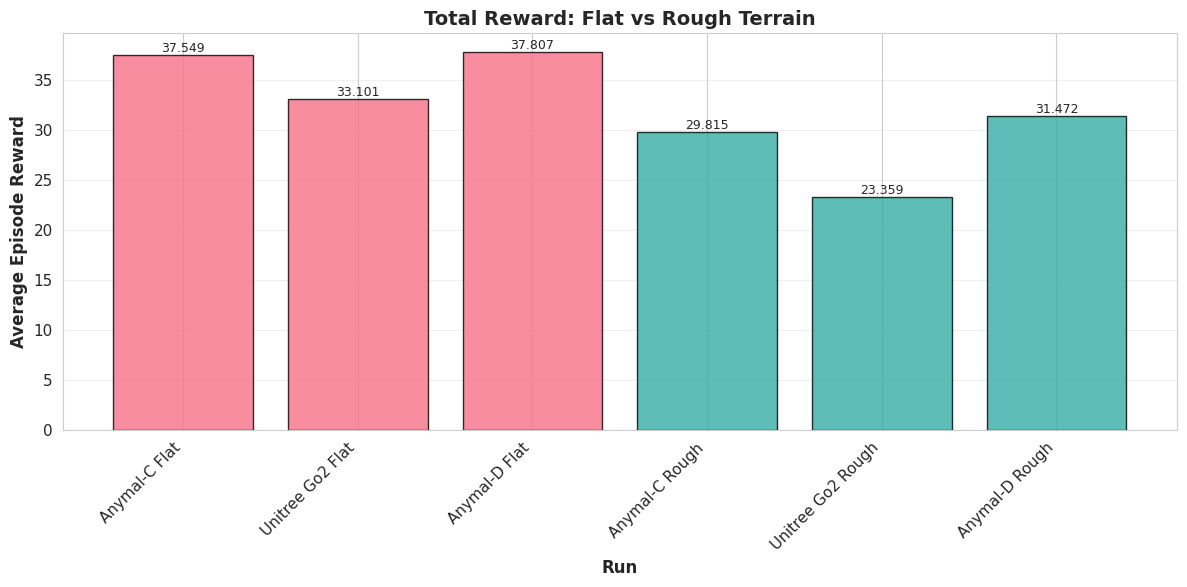

In [18]:
# Total reward comparison
metric_col = 'mean_reward'
if metric_col in metrics_df.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_comparison_bar(
        metrics_df,
        'flat_vs_rough',
        metric_col,
        title='Total Reward: Flat vs Rough Terrain',
        ylabel='Average Episode Reward',
        ax=ax
    )
    # plt.savefig(OUTPUT_DIR / "flat_vs_rough_reward.png", dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f"Metric {metric_col} not available")


## 3. Comparison: Robot Platforms (Rough Terrain)

Compare different robot platforms on rough terrain.


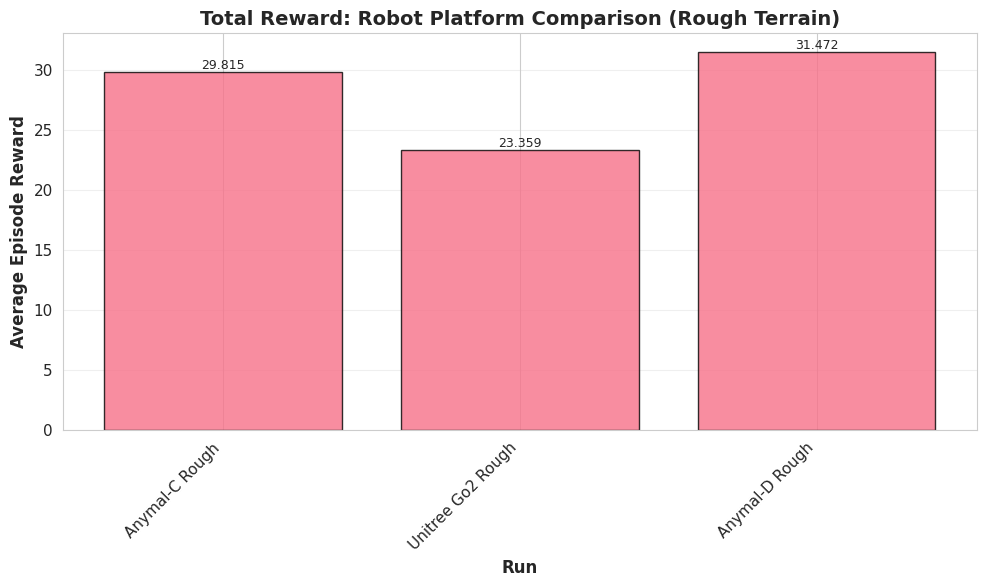

In [19]:
# Robot comparison on rough terrain
metric_col = 'mean_reward'
if metric_col in metrics_df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_comparison_bar(
        metrics_df,
        'robot_comparison_rough',
        metric_col,
        title='Total Reward: Robot Platform Comparison (Rough Terrain)',
        ylabel='Average Episode Reward',
        ax=ax
    )
    # plt.savefig(OUTPUT_DIR / "robot_comparison_rough_reward.png", dpi=150, bbox_inches='tight')
    plt.show()


## 6. Comprehensive Chart Metrics

Grouped bar charts showing multiple metrics across different runs for easy comparison.


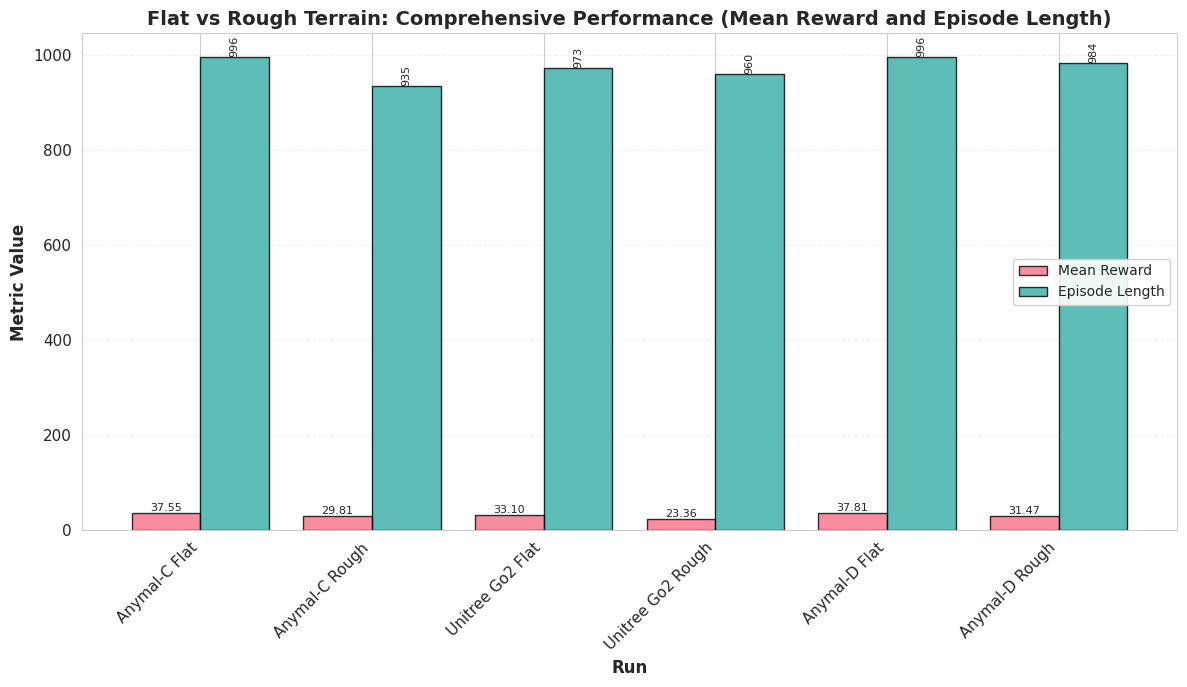

In [ ]:
# Comprehensive Metrics: Flat vs Rough (Grouped Bar Chart)
metrics = [
    'mean_reward',
    'episode_length',
]

# Filter to available metrics
available_metrics = [m for m in metrics if m in metrics_df.columns]

if len(available_metrics) >= 2:
    plot_multi_metric_bars(
        metrics_df,
        'flat_vs_rough',
        available_metrics,
        title='Flat vs Rough Terrain: Comprehensive Performance (Mean Reward and Episode Length)'
    )
    # plt.savefig(OUTPUT_DIR / 'flat_vs_rough_comprehensive.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f'Not enough metrics. Available: {available_metrics}')


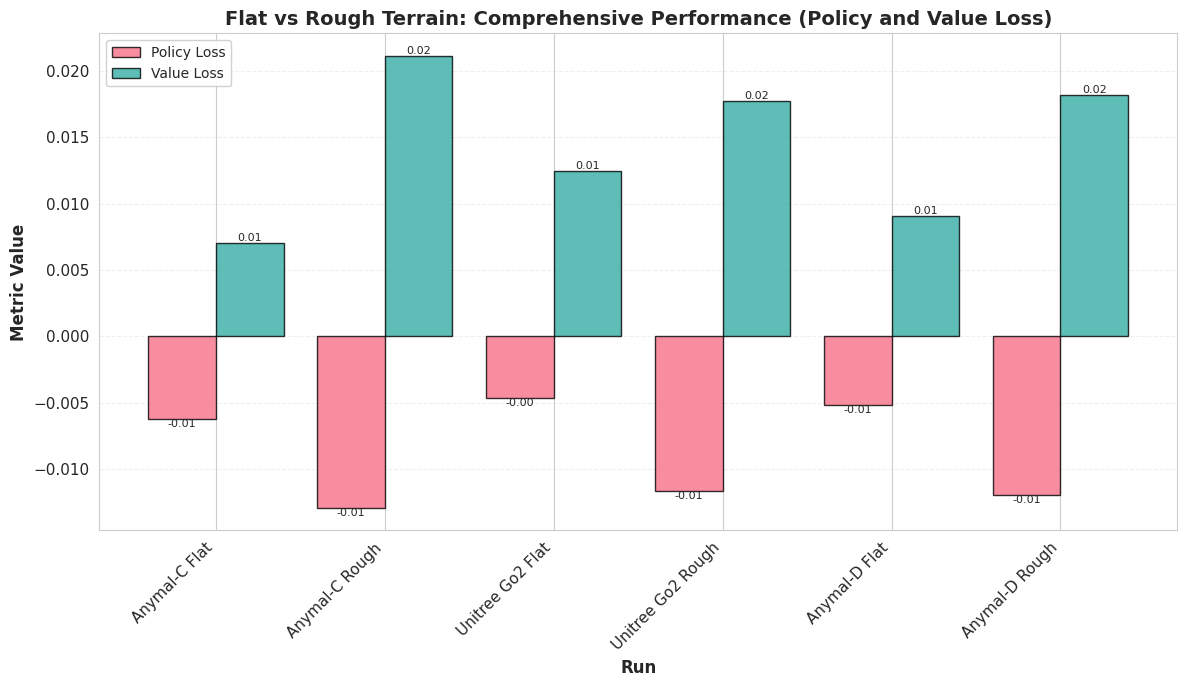

In [ ]:
# Comprehensive Metrics: Flat vs Rough (Grouped Bar Chart)
metrics = [
    'policy_loss',
    'value_loss',
]

# Filter to available metrics
available_metrics = [m for m in metrics if m in metrics_df.columns]

if len(available_metrics) >= 2:
    plot_multi_metric_bars(
        metrics_df,
        'flat_vs_rough',
        available_metrics,
        title='Flat vs Rough Terrain: Comprehensive Performance (Policy and Value Loss)'
    )
    # plt.savefig(OUTPUT_DIR / 'flat_vs_rough_comprehensive.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f'Not enough metrics. Available: {available_metrics}')


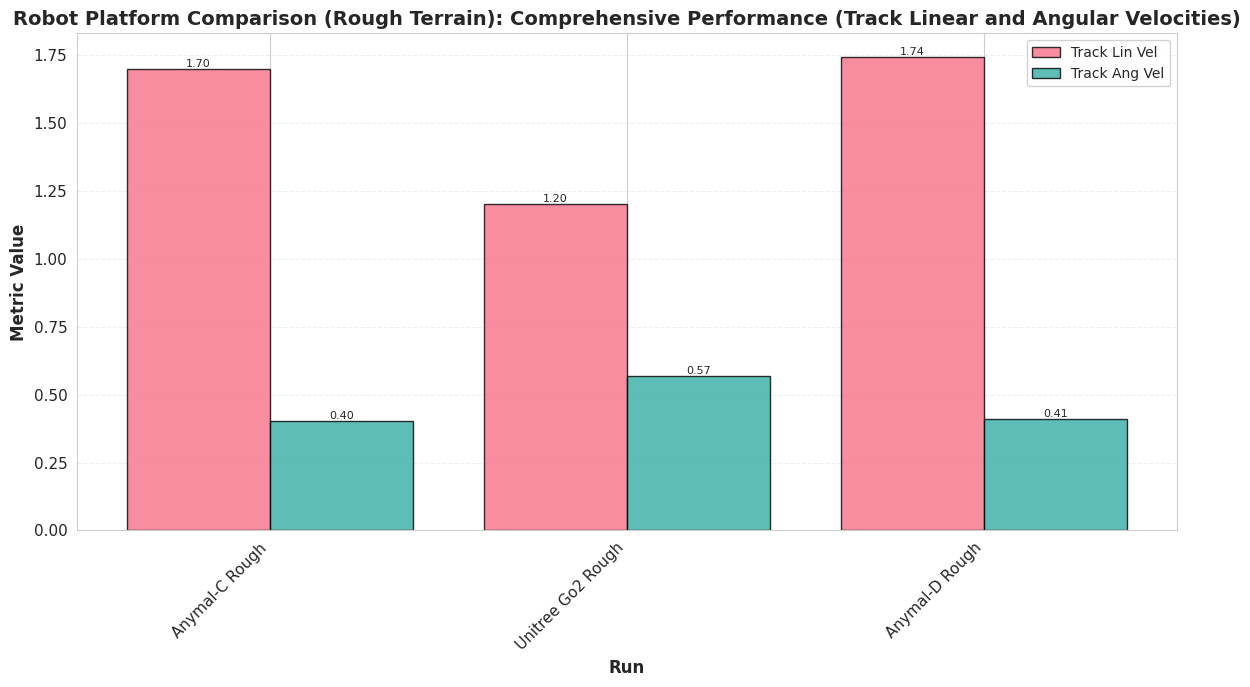

In [ ]:
# Comprehensive Metrics: Robot Comparison (Grouped Bar Chart)
metrics = [
    'track_lin_vel',
    'track_ang_vel',
]

available_metrics = [m for m in metrics if m in metrics_df.columns]

if len(available_metrics) >= 2:
    plot_multi_metric_bars(
        metrics_df,
        'robot_comparison_rough',
        available_metrics,
        title='Robot Platform Comparison (Rough Terrain): Comprehensive Performance (Track Linear and Angular Velocities)'
    )
    # plt.savefig(OUTPUT_DIR / 'robot_comparison_comprehensive.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f'Not enough metrics. Available: {available_metrics}')


## 7. Statistical Summary and Insights

Generate statistical summaries and key insights from the comparisons.


In [23]:
# Statistical summary by category
print("="*80)
print("STATISTICAL SUMMARY")
print("="*80)

summary_cols = ['mean_reward', 'episode_length']
available_summary_cols = [c for c in summary_cols if c in metrics_df.columns]

if available_summary_cols:
    print("\nSummary by Category:")
    category_summary = metrics_df.groupby('category')[available_summary_cols].agg(['mean', 'std', 'min', 'max'])
    display(category_summary)
    
    # Full metrics table
    print("\nFull Metrics Table (Latest Checkpoint Values):")
    display_cols = ['display_name', 'experiment', 'category'] + available_summary_cols
    full_table = metrics_df[display_cols].sort_values(by='mean_reward', ascending=False)
    display(full_table)
    
    # Save summary
    # full_table.to_csv(OUTPUT_DIR / "full_metrics_summary.csv", index=False)
    # print(f"\nFull summary saved to: {OUTPUT_DIR / 'full_metrics_summary.csv'}")


STATISTICAL SUMMARY

Summary by Category:


mean_reward                                 episode_length  \
                mean       std        min        max           mean   
category                                                              
flat       36.152056  2.645627  33.100784  37.806713     988.146667   
rough      28.215296  4.286585  23.358986  31.472305     959.410014   

                                             
                std         min         max  
category                                     
flat      12.996158  973.140015  995.669983  
rough     24.616271  934.650024  983.880005


Full Metrics Table (Latest Checkpoint Values):


,display_name,experiment,category,mean_reward,episode_length
4,Anymal-D Flat,anymal_d_flat,flat,37.806713,995.669983
0,Anymal-C Flat,anymal_c_flat,flat,37.548672,995.630005
2,Unitree Go2 Flat,unitree_go2_flat,flat,33.100784,973.140015
5,Anymal-D Rough,anymal_d_rough,rough,31.472305,983.880005
1,Anymal-C Rough,anymal_c_rough,rough,29.814598,934.650024
3,Unitree Go2 Rough,unitree_go2_rough,rough,23.358986,959.700012


In [24]:
# Generate key insights
print("="*80)
print("KEY INSIGHTS AND FINDINGS")
print("="*80)

insights = []

# 1. Flat vs Rough performance
flat_runs = metrics_df[metrics_df['category'] == 'flat']
rough_runs = metrics_df[metrics_df['category'] == 'rough']

if 'mean_reward' in metrics_df.columns:
    flat_mean = flat_runs['mean_reward'].mean()
    rough_mean = rough_runs['mean_reward'].mean()
    
    if pd.notna(flat_mean) and pd.notna(rough_mean):
        diff_pct = ((rough_mean - flat_mean) / abs(flat_mean)) * 100 if flat_mean != 0 else 0
        insights.append({
            'Finding': 'Terrain Difficulty Impact',
            'Detail': f"Average reward on rough terrain is {diff_pct:.1f} % { 'higher' if diff_pct > 0 else 'lower' } than flat terrain",
            'Flat Mean': f"{flat_mean:.3f}",
            'Rough Mean': f"{rough_mean:.3f}"
        })

# 2. Best performing policy
if 'mean_reward' in metrics_df.columns:
    best_run = metrics_df.loc[metrics_df['mean_reward'].idxmax()]
    insights.append({
        'Finding': 'Best Performing Policy',
        'Detail': f"{best_run['display_name']} achieves the highest total reward: {best_run['mean_reward']:.3f}",
        'Experiment': best_run['experiment']
    })

# 3. Training stability
if 'episode_length' in metrics_df.columns:
    stable_runs = metrics_df[metrics_df['episode_length'] > metrics_df['episode_length'].quantile(0.75)]
    insights.append({
        'Finding': 'Training Stability',
        'Detail': f"{len(stable_runs)} policies show high episode stability (top quartile)",
        'Top Stable Policies': ', '.join(stable_runs['display_name'].tolist()[:5])
    })

# Print insights
for i, insight in enumerate(insights, 1):
    print(f"\n{i}. {insight['Finding']}")
    print(f"   {insight['Detail']}")
    for key, value in insight.items():
        if key not in ['Finding', 'Detail']:
            print(f"   {key}: {value}")

# Save insights
insights_df = pd.DataFrame(insights)
    # insights_df.to_csv(OUTPUT_DIR / "insights.csv", index=False)
    # print(f"\n\nInsights saved to: {OUTPUT_DIR / 'insights.csv'}")


KEY INSIGHTS AND FINDINGS

1. Terrain Difficulty Impact
   Average reward on rough terrain is -22.0 % lower than flat terrain
   Flat Mean: 36.152
   Rough Mean: 28.215

2. Best Performing Policy
   Anymal-D Flat achieves the highest total reward: 37.807
   Experiment: anymal_d_flat

3. Training Stability
   2 policies show high episode stability (top quartile)
   Top Stable Policies: Anymal-C Flat, Anymal-D Flat
